# QOSF Screening task 1


 Made by Paul San Sebastian Sein. In this notebook we'll try to build function that uses a quantum circuit in order to compare two integer and return the biggest one. This problem is already solved in the [literature](https://www.researchgate.net/publication/228574906_Quantum_bit_string_comparator_Circuits_and_applications), but let's try to build our own circuit! 

We will use Pennylane to build our quantum circuits and run them on a simulator.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

To make the comparison of the integers (let's call them $a$ and $b$), we will represent them in binary strings. We will build a circuit that compares first the most significant bits and an ancilla qubit will store whether they are equal or not. This comparison block is made for every bit in the binary representation of both integers, but the most signifficant non-equal bits will determine which integer is the biggest. The circuti will have two output bits that we will measeure ($O_1$ and $O_2$). This output bits will return $|O_1 O_2\rangle = |10\rangle$ if the first integer is bigger, $|O_1 O_2\rangle = |01\rangle$ if the second integer is bigger and $|O_1 O_2\rangle = |00\rangle$ if they are equal.

## Bit-wise comparing block:

![Conparing Block](./images/comparing_block.png)

In [42]:
def comparing_block(pos1,pos2,a,b):

    #We initialize the binary bits using X gates
    if a==1:
        qml.PauliX(wires=pos1)
    if b ==1:
        qml.PauliX(wires=pos2)
    
    qml.PauliX(wires=pos2)
    qml.Toffoli(wires=(pos1,pos2,pos2+1))
    qml.PauliX(wires=pos1)
    qml.PauliX(wires=pos2)
    qml.Toffoli(wires=(pos1,pos2,pos2+2))
    qml.PauliX(wires=pos1)
    return #We don't return any measuremen't because this will be a building block of a larger circuit

Let's check this function returns the expected output:

In [59]:
def temp(pos1,pos2,a,b):
    comparing_block(pos1,pos2,a,b)
    return qml.sample(qml.PauliZ(pos2+1)), qml.sample(qml.PauliZ(pos2+2))

dev = qml.device("default.qubit", wires=4, shots=1)
node = qml.QNode(temp, dev)


for (a,b) in [(0,0),(0,1),(1,0),(1,1)]:
    output = np.hstack(node(0,1,a,b))
    output = (1-output)/2 #Map the measured values from {1,-1} to {0,1}
    print(f"a={a}, b={b}, output={output}")

a=0, b=0, output=[0. 0.]
a=0, b=1, output=[0. 1.]
a=1, b=0, output=[1. 0.]
a=1, b=1, output=[0. 0.]


## Ensemble of comparing blocks

We will introduce a comparing block for each bit of both binary strings and we will store the outputs of in ancillary qubits. We will connect those outputs using Toffoli gates, in such a way that, in the case of both bits being equal, the output of the comparison of the  next most significant bit is added to the output register. For example, if the bit strings have 3 digits:

![Conparing Block](./images/ensemble.png)

In [118]:
def ensemble(stringA,stringB):
    '''
    It is assumed both string to be "str" type and 
     both strings should have the same length!

    '''
    n_blocks=len(stringA)
    n_qubits= 5*n_blocks-1      #"5" comes from each block needing 4 qubit +1 ancilla qubit

    for i in range(n_blocks):
        pos1 = i*5              #The first qubit of the current block
        comparing_block(pos1,pos1+1,int(stringA[i]),int(stringB[i]))

        if i != n_blocks-1:     #Don't do it in the last block

                                #Flip ancilla if both bits are equal
            qml.PauliX(pos1+2)  # These NOT gates are because the Toffoli must activate when control qubits are 0
            qml.PauliX(pos1+3)
            qml.Toffoli(wires=[pos1+2,pos1+3,pos1+4])
            qml.PauliX(pos1+2)
            qml.PauliX(pos1+3)

    for i in range(n_blocks-1,-1,-1):
        pos1 = i*5              #The first qubit of the current block

        if i != n_blocks-1:     #Don't do it in the last block
            pos2 = (i+1)*5      #The first qubit of the next qubit
            qml.Toffoli(wires=[pos2+2,pos1+4,pos1+2])
            qml.Toffoli(wires=[pos2+3, pos1+4, pos1+3])



    return qml.sample(qml.PauliZ(2)),qml.sample(qml.PauliZ(3))

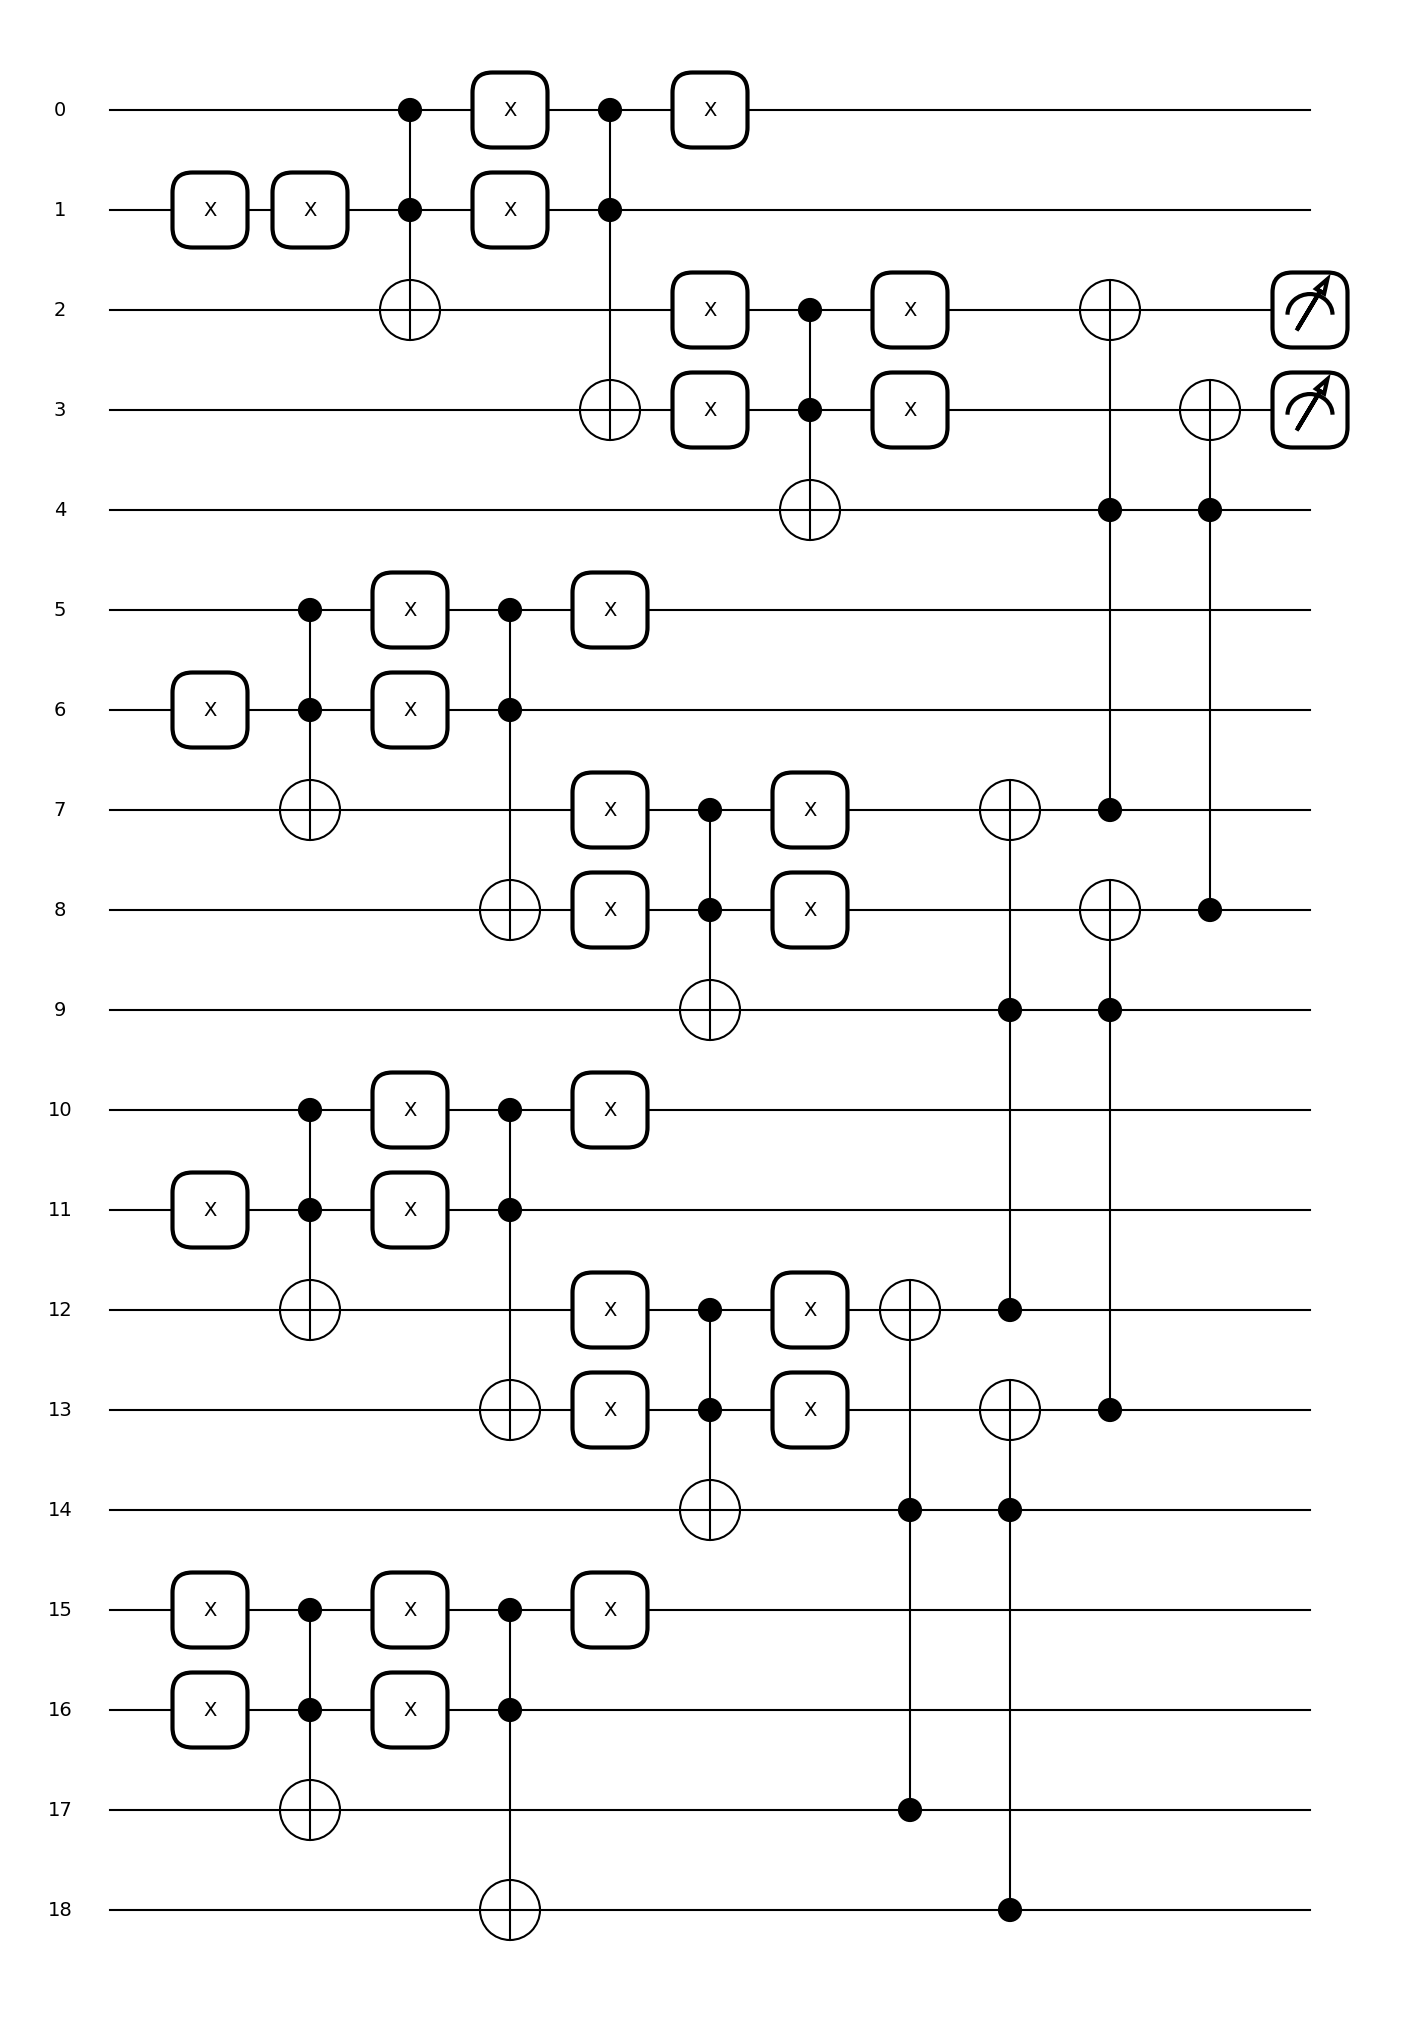

In [164]:
a="0001"
b="1000"

n_qubits=5*len(a)-1
dev = qml.device("default.qubit", wires=n_qubits, shots=1)
node = qml.QNode(ensemble, dev)

fig, ax = qml.draw_mpl(node , decimals=1)(a,b)
plt.show()

## Final function


The Ansatz is ready! The only thing left is to build a function that takes integers as an input, writes them as binary strings and formats correctly the output of the circuit. Note that we can also compare negative numbers adding the sign as the most signifficant bit.

In [170]:
def find_the_largest_number (number_1, number_2):



    #Formating the integers-------------------

    sign1 = int((np.sign(number_1)+1)/2)            #Store the sign
    sign2 = int((np.sign(number_2)+1)/2)            #Map the sign coefficient from {-1,1} to {0,1}
    signs=[sign1,sign2]

    string1 = "{0:b}".format(abs(number_1))         #Convert integers to binary strings
    string2 = "{0:b}".format(abs(number_2))

    n_longest_string = max(len(string1), len(string2))
    
    formated_strings=[]

    for string, sign in zip([string1,string2],signs):

        padded = "0"*(n_longest_string-len(string))+string      #Pad the strings to have the same length 
        formated_strings.append(str(sign)+padded)               #Add the sign as the most signifficant bit


    n_qubits=5*len(formated_strings[0])-1

    print(formated_strings)

    #Quantum circuit--------------
    dev = qml.device("default.qubit", wires=n_qubits, shots=1)  #Declare the device
    node = qml.QNode(ensemble, dev)                             #Create a QNode with the ansatz and the device
    
    output = node(formated_strings[0],formated_strings[1])      #Execute the quantum circuit
    
    
    
    print(output)

find_the_largest_number (3, -17)

['100011', '010001']


In [150]:
a="{0:b}".format(abs(11)) 
type(a) 

str